# *Monod* demonstration: calculating noise decompositions

We ran the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw data, we can apply a non-parametric normalization and variance stabilization procedure to, hypothetically, reduce technical variation and make different genes more comparable. Further, given a full model fit and its maximum likelihood parameters, we can calculate plug-in estimates of the relative variance contributions from intrinsic (discrete) noise, extrinsic (bursty) noise, and technical (sequencing) noise.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:

#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")

In [3]:
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [4]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dn1 = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 

dir_string1 = './fits/gg_220527_021_allen_celltypes_1'

res = [dir_string1+'/'+x for x in dn1]


sr_strings = [x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in res]

sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] 
n_datasets = len(sr_strings)


In [5]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr = load_search_results(sr_strings[j])
    
    sd_arr.append(sd)
    sr_arr.append(sr)

INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220527_0

## Noise computations

We are interested in the relationship between the noise eliminated by the normalization and the sources of variance in the mechanistic fits. Therefore, we compute the amount of noise *eliminated* by the log1pPF normalization on the raw spliced count data, and compare it to the amount of noise resulting from *biological* sources according to the fit. If the two are correlated, then it appears that normalization mostly eliminates biological variation; if they are anti-correlated, then normalization mostly eliminates technical variation.

In [69]:
# import copy
S = np.copy(sd_arr[0].S)

In [70]:
S[0,0]=1e10

In [72]:
sd_arr[0].S

array([[2., 6., 6., ..., 3., 2., 4.],
       [0., 0., 2., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [2., 6., 4., ..., 0., 0., 1.],
       [2., 3., 5., ..., 0., 0., 0.],
       [2., 6., 4., ..., 5., 0., 1.]])

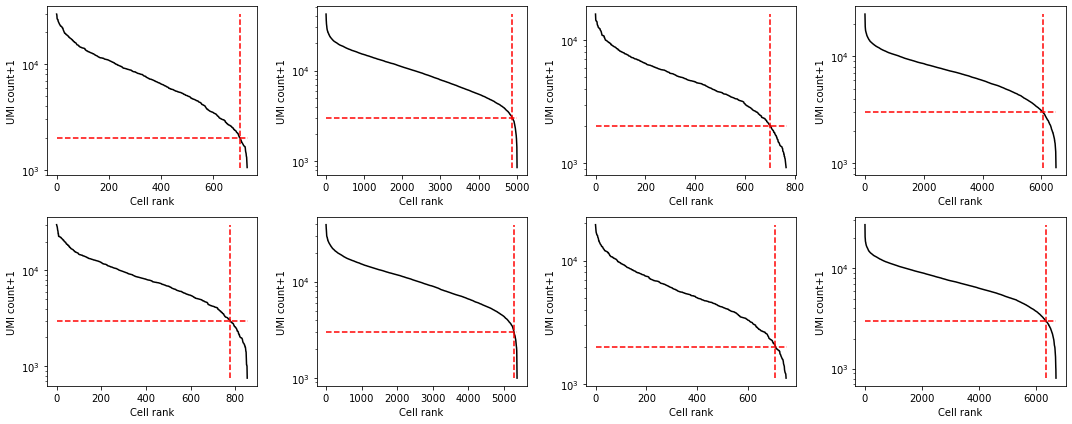

In [9]:
sz=(2,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(15,6))
thr = [2e3, 3e3, 2e3, 3e3, 3e3, 3e3, 2e3, 3e3]
for j in range(n_datasets):
    axloc=np.unravel_index(j,sz)
    sd_arr[j].knee_plot(ax1=ax1[axloc],thr=thr[j],viz=True)
fig1.tight_layout()

In [77]:
sd_arr[1].S.shape

(3000, 5010)

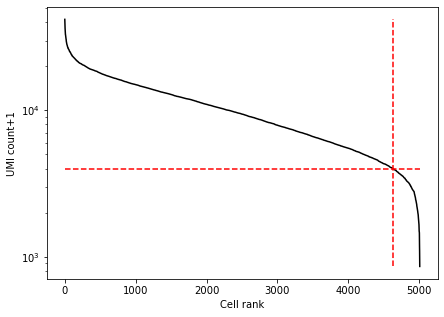

In [76]:
_=knee_plot(sd_arr[1],thr=4e3)

In [16]:
f_tech_naive = []
f_mech = []

for j in range(n_datasets):
#     f_tech_naive.append(sd_arr[j].get_noise_decomp(knee_thr=thr[j])[:,1,1])
    f_tech_naive.append(get_noise_decomp_(sd_arr[j],knee_thr=thr[j])[:,1,1])

    sr_arr[j].find_sampling_optimum()
    d = sr_arr[j].get_noise_decomp()
    f_mech.append(d[:,1,1]) #bursting noise
    
f_tech_naive = np.asarray(f_tech_naive)
f_mech = np.asarray(f_mech)

AttributeError: 'NoneType' object has no attribute 'shape'

In [15]:
def get_noise_decomp_(self,sizefactor = 'pf',lognormalize=True,pcount=0,knee_thr=None):
    """
    This method performs normalization and variance stabilization on the raw data, and
    reports the fractions of normalized variance retained and removed as a result of the process.

    Input:
    sizefactor: what size factor to use. 
        'pf': Proportional fitting; set the size of each cell to the mean size.
        a number: use this number (e.g., 1e4 for cp10k).
    lognormalize: whether to do log(1+x).
    pcount: pseudocount added to ensure division by zero does not occur.

    Output: 
    f: array with size n_genes x 2 x 2. 
        dim 0: gene
        dim 1: variance fraction (retained, discarded)
        dim 2: species (unspliced, spliced)
    The unspliced and spliced species are analyzed independently.
    """
    f = np.zeros((self.n_genes,2,2)) #genes -- bio vs tech -- species

    S = np.copy(self.S)
    U = np.copy(self.U)

    if knee_thr is not None:
        cf = self.knee_plot(thr=knee_thr)
        S = S[:,cf]
        U = U[:,cf]
    print(cf.shape)
    CV2 = S.var(1)/S.mean(1)**2

    if sizefactor == 'pf':
        C = S.sum(0).mean()
    else:
        C = sizefactor
    S_ = S/(S.sum(0)[None,:]+pcount)*C
    if lognormalize:
        S_ = np.log(1+S_)
    CV2_ = S_.var(1)/S_.mean(1)**2

    f[:,0,1] = CV2_/CV2
    f[:,1,1] = 1-f[:,0,1]

    CV2 = U.var(1)/U.mean(1)**2

    if sizefactor == 'pf':
        C = U.sum(0).mean()
    else:
        C = sizefactor
    U_ = U/(U.sum(0)[None,:]+pcount)*C
    if lognormalize:
        U_ = np.log(1+U_)
    CV2_ = U_.var(1)/U_.mean(1)**2

    f[:,0,0] = CV2_/CV2
    f[:,1,0] = 1-f[:,0,0]

    return f


In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_tech_naive[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j%len(Demuth)])
plt.xlabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)
plt.ylabel('Density',fontsize=fs)

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_mech[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j%len(Demuth)])
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel('Density',fontsize=fs)

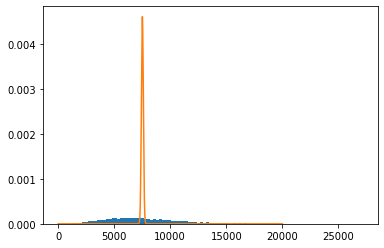

In [32]:
plt.hist( sd.S.sum(0),100,density=True)
x=np.arange(20000)
plt.plot(x,scipy.stats.poisson.pmf(x,sd.S.sum(0).mean()))

The result for these (highly homogeneous) datasets appears to suggest that the normalization procedure mostly eliminates biological noise. However, this interpretation is mostly qualitative, because the procedure is not guaranteed to reduce variance, and sometimes increases it. For all other datasets we have investigated, it greatly increases the coefficient of variation.

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.scatter(f_mech[j],f_tech_naive[j],s=3,alpha=0.9,c=Demuth[j%len(Demuth)])
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)

analysis_dir_string = dir_string1+'/analysis_figures'
fig_string = analysis_dir_string+'/CV2_noise.png'
# plt.xlim([-1,2])
# plt.ylim([-1,2])
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [27]:
np.sqrt(20000)

141.4213562373095

In [68]:
len(sd_arr)

8

In [13]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 14 seconds.
